<a href="https://colab.research.google.com/github/cheolhakja/fine-dust-prediction/blob/main/%EB%AA%A8%EB%8D%B8_%ED%95%99%EC%8A%B5_%EC%98%88%EC%B8%A1_pm10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

# [1] 두 개의 CSV 파일을 읽어서
df1 = pd.read_csv('/content/drive/MyDrive/graduation_project/train_202506.csv')
df2 = pd.read_csv('/content/drive/MyDrive/graduation_project/train_202505.csv')

df3 = pd.read_csv('/content/drive/MyDrive/graduation_project/train_202504.csv')

# [2] concat으로 붙인다
df = pd.concat([df1, df2, df3], ignore_index=True)


print(len(df1), len(df2),len(df3),len(df))



Mounted at /content/drive
55747 78952 57266 191965


In [ ]:
###########################################################
### 학습 시작
###########################################################

print(df.columns.tolist())



['so2Value', 'coValue', 'o3Value', 'no2Value', 'pm10Value', 'pm25Value', 'stationName', 'datetime', 'addr', 'dmX', 'dmY', 'distance', 'V1_stationName', 'V2_stationName', 'V3_stationName', 'V4_stationName', 'V5_stationName', '구/시/군', 'aws지점코드', '풍속(m/s)', '풍향(deg)', '기온(°C)', '강수12h', 'V1_so2Value', 'V1_coValue', 'V1_no2Value', 'V1_o3Value', 'V1_pm25Value', 'V1_pm10Value', 'V1_temp', 'V1_wind', 'V1_rain12h', 'V2_so2Value', 'V2_coValue', 'V2_no2Value', 'V2_o3Value', 'V2_pm25Value', 'V2_pm10Value', 'V2_temp', 'V2_wind', 'V2_rain12h', 'V3_so2Value', 'V3_coValue', 'V3_no2Value', 'V3_o3Value', 'V3_pm25Value', 'V3_pm10Value', 'V3_temp', 'V3_wind', 'V3_rain12h', 'V4_so2Value', 'V4_coValue', 'V4_no2Value', 'V4_o3Value', 'V4_pm25Value', 'V4_pm10Value', 'V4_temp', 'V4_wind', 'V4_rain12h', 'V5_so2Value', 'V5_coValue', 'V5_no2Value', 'V5_o3Value', 'V5_pm25Value', 'V5_pm10Value', 'V5_temp', 'V5_wind', 'V5_rain12h']


In [ ]:
features = []

for i in range(1, 6):
    features.extend([
        f'V{i}_pm10Value',
        # f'V{i}_pm25Value',
        f'V{i}_so2Value',
        f'V{i}_coValue',
        f'V{i}_no2Value',
        f'V{i}_o3Value',
        f'V{i}_temp',
        f'V{i}_wind',
        f'V{i}_rain12h'
    ])

# target = 'pm25Value'
target = 'pm10Value'


In [ ]:
X = df[features]
y = df[target]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
# # 남아 있는 '-'가 있는 셀 찾아서 출력
# X_check = X_train.astype(str)
# mask_remain = X_check.apply(lambda row: row.str.contains('-'), axis=1)

# # '-' 포함된 행 출력
# X_with_dash = X_train[mask_remain]
# print(X_with_dash)


In [ ]:

import numpy as np
import pandas as pd
import xgboost as xgb
def clean_dataframe(df, y):
    # 1. 문자열로 전체 변환 후 이상한 값 처리
    df = df.astype(str).replace(['-', '_', ' ', 'nan', 'NaN', 'None'], np.nan)

    # 2. 숫자로 변환 (변환 실패 시 NaN)
    df = df.apply(pd.to_numeric, errors='coerce')

    # 3. NaN → 0으로 대체
    df = df.fillna(0)

    # y도 인덱스 맞춰서 처리
    y_clean = y.reset_index(drop=True)
    df_clean = df.reset_index(drop=True)
    return df_clean, y_clean

# 적용
X_train, y_train = clean_dataframe(X_train, y_train)
X_valid, y_valid = clean_dataframe(X_valid, y_valid)

# 확인 (이제는 절대로 문자열 없음)
print("문자열이 남아 있는지 검사:", X_train.applymap(type).eq(str).any().any())  # False여야 함

# y도 문자열 제거 및 숫자 변환
def clean_target(y):
    y = y.astype(str).replace(['-', '_', ' ', 'nan', 'NaN', 'None'], np.nan)
    y = pd.to_numeric(y, errors='coerce').fillna(0)
    return y

# 적용
y_train = clean_target(y_train)
y_valid = clean_target(y_valid)


# DMatrix 생성
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

print(dtrain)
print(dvalid)








/tmp/ipython-input-7-2059267757.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print("문자열이 남아 있는지 검사:", X_train.applymap(type).eq(str).any().any())  # False여야 함


문자열이 남아 있는지 검사: False


In [ ]:
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.1,
    'max_depth': 6,
    'seed': 42
}

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=100,
    evals=[(dtrain, 'train'), (dvalid, 'valid')],
    early_stopping_rounds=10,
    verbose_eval=True
)


[0]	train-rmse:18.79066	valid-rmse:18.78683
[1]	train-rmse:17.58950	valid-rmse:17.59038
[2]	train-rmse:16.54280	valid-rmse:16.54904
[3]	train-rmse:15.63824	valid-rmse:15.64969
[4]	train-rmse:14.86052	valid-rmse:14.88112
[5]	train-rmse:14.18941	valid-rmse:14.21908
[6]	train-rmse:13.61394	valid-rmse:13.65561
[7]	train-rmse:13.12629	valid-rmse:13.17604
[8]	train-rmse:12.70994	valid-rmse:12.76728
[9]	train-rmse:12.35554	valid-rmse:12.42443
[10]	train-rmse:12.05908	valid-rmse:12.13683
[11]	train-rmse:11.80636	valid-rmse:11.89322
[12]	train-rmse:11.59581	valid-rmse:11.69479
[13]	train-rmse:11.41574	valid-rmse:11.52363
[14]	train-rmse:11.26347	valid-rmse:11.38184
[15]	train-rmse:11.13484	valid-rmse:11.25984
[16]	train-rmse:11.02564	valid-rmse:11.15802
[17]	train-rmse:10.93137	valid-rmse:11.07204
[18]	train-rmse:10.85174	valid-rmse:10.99931
[19]	train-rmse:10.78036	valid-rmse:10.93377
[20]	train-rmse:10.72116	valid-rmse:10.88330
[21]	train-rmse:10.67119	valid-rmse:10.84024
[22]	train-rmse:10.6

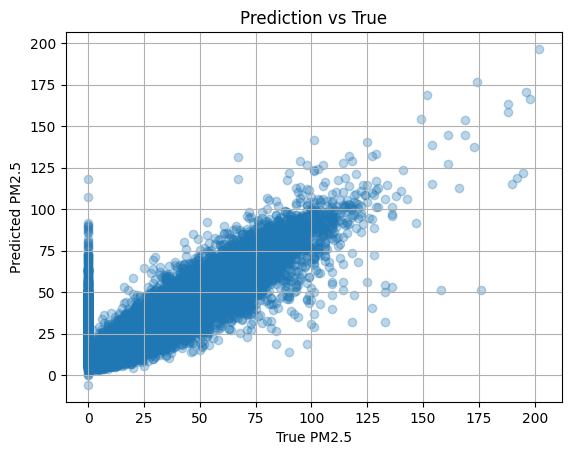

In [ ]:
preds = model.predict(dvalid)

import matplotlib.pyplot as plt
plt.scatter(y_valid, preds, alpha=0.3)
plt.xlabel("True PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("Prediction vs True")
plt.grid(True)
plt.show()


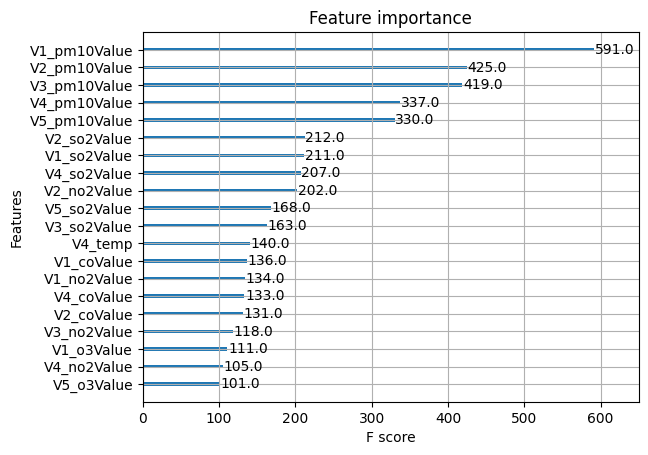

In [ ]:
xgb.plot_importance(model, max_num_features=20)
plt.show()


In [ ]:
"""
✅ 학습한 모델을 Google Drive에 .json으로 저장하는 코드
"""
# 1. Google Drive 내 원하는 경로 지정
model_path = '/content/drive/MyDrive/graduation_project/pm10_model.json'

# 2. 모델 저장
model.save_model(model_path)

print("✅ 저장 완료:", model_path)

✅ 저장 완료: /content/drive/MyDrive/graduation_project/pm10_model.json


In [ ]:
"""
✅ 그다음 Colab에서 다시 불러오고 예측하려면
"""
# import xgboost as xgb

# # 저장한 모델 불러오기
# loaded_model = xgb.Booster()
# loaded_model.load_model('/content/drive/MyDrive/graduation_project/pm25_model.json')

# # 예측 (DMatrix 사용해야 함)
# dtest = xgb.DMatrix(X_test)
# y_pred = loaded_model.predict(dtest)

'\n✅ 그다음 Colab에서 다시 불러오고 예측하려면\n'